# Simple Inference with Edge TPU

So, let's examine a very simple scenario. You have trained you model, quantized and compiled it to be compatible with Edge TPU. And now you want to run it. Let's see how.

For this tutorial we will be using a model trained to recognize different bird species. Let get our pretrained model:

In [1]:
!wget https://dl.google.com/coral/canned_models/mobilenet_v2_1.0_224_inat_bird_quant_edgetpu.tflite -P data

--2019-05-06 11:29:21--  https://dl.google.com/coral/canned_models/mobilenet_v2_1.0_224_inat_bird_quant_edgetpu.tflite
Resolving dl.google.com (dl.google.com)... 216.58.215.78, 2a00:1450:401b:806::200e
Connecting to dl.google.com (dl.google.com)|216.58.215.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4084056 (3,9M) [application/octet-stream]
Saving to: ‘data/mobilenet_v2_1.0_224_inat_bird_quant_edgetpu.tflite’

mobilenet_v2_1.0_22 100%[===================>]   3,89M  9,10MB/s    in 0,4s    

2019-05-06 11:29:22 (9,10 MB/s) - ‘data/mobilenet_v2_1.0_224_inat_bird_quant_edgetpu.tflite’ saved [4084056/4084056]



We will also need the labels to decode the output of the neural network (in order to know which output neuron corresonds to which class):

In [2]:
!wget https://dl.google.com/coral/canned_models/inat_bird_labels.txt -P data

--2019-05-06 11:29:24--  https://dl.google.com/coral/canned_models/inat_bird_labels.txt
Resolving dl.google.com (dl.google.com)... 216.58.215.78, 2a00:1450:401b:806::200e
Connecting to dl.google.com (dl.google.com)|216.58.215.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40895 (40K) [text/plain]
Saving to: ‘data/inat_bird_labels.txt’

inat_bird_labels.tx 100%[===================>]  39,94K  --.-KB/s    in 0,08s   

2019-05-06 11:29:24 (513 KB/s) - ‘data/inat_bird_labels.txt’ saved [40895/40895]



Let's also get a few images to classify...

In [3]:
!wget https://coral.withgoogle.com/static/images/parrot.jpg -P data
!wget https://www.economist.com/sites/default/files/20181006_BLP501.jpg -P data

--2019-05-06 11:29:26--  https://coral.withgoogle.com/static/images/parrot.jpg
Resolving coral.withgoogle.com (coral.withgoogle.com)... 172.217.21.241, 2a00:1450:4001:819::2011
Connecting to coral.withgoogle.com (coral.withgoogle.com)|172.217.21.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94865 (93K) [image/jpeg]
Saving to: ‘data/parrot.jpg’

parrot.jpg          100%[===================>]  92,64K  --.-KB/s    in 0,1s    

2019-05-06 11:29:26 (929 KB/s) - ‘data/parrot.jpg’ saved [94865/94865]

--2019-05-06 11:29:26--  https://www.economist.com/sites/default/files/20181006_BLP501.jpg
Resolving www.economist.com (www.economist.com)... 45.60.183.108
Connecting to www.economist.com (www.economist.com)|45.60.183.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105833 (103K) [image/jpeg]
Saving to: ‘data/20181006_BLP501.jpg’

20181006_BLP501.jpg 100%[===================>] 103,35K   394KB/s    in 0,3s    

2019-05-06 11:29:27 (394 

So, first let's just read the labels from the label file:

In [4]:
import re
with open('data/inat_bird_labels.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
labels = {}
for line in lines:
    pair = re.split(r'[:\s]+', line.strip(), maxsplit=1)
    labels[int(pair[0])] = pair[1].strip()

Nothing extraordinary done so far...

In [5]:
print(labels)

{0: "Haemorhous cassinii (Cassin's Finch)", 1: 'Aramus guarauna (Limpkin)', 2: 'Rupornis magnirostris (Roadside Hawk)', 3: 'Cyanocitta cristata (Blue Jay)', 4: "Cyanocitta stelleri (Steller's Jay)", 5: 'Balearica regulorum (Grey Crowned Crane)', 6: 'Pyrocephalus rubinus (Vermilion Flycatcher)', 7: 'Recurvirostra americana (American Avocet)', 8: 'Ardeotis kori (Kori Bustard)', 9: 'Pica nuttalli (Yellow-billed Magpie)', 10: 'Perisoreus canadensis (Gray Jay)', 11: 'Antigone canadensis (Sandhill Crane)', 12: 'Parkesia noveboracensis (Northern Waterthrush)', 13: 'Ardea herodias occidentalis (Great White Heron)', 14: 'Porzana carolina (Sora)', 15: 'Anas platyrhynchos diazi (Mexican Duck)', 16: 'Motacilla cinerea (Grey Wagtail)', 17: 'Empidonax difficilis (Pacific-slope Flycatcher)', 18: 'Empidonax minimus (Least Flycatcher)', 19: 'Empidonax fulvifrons (Buff-breasted Flycatcher)', 20: 'Empidonax traillii (Willow Flycatcher)', 21: "Empidonax hammondii (Hammond's Flycatcher)", 22: 'Empidonax oc

Now we are ready to start classifying images with our (USB) Edge TPU. Be sure to plug in your TPU (preferably in a USB 3 port).

First, we will initialize our classification engine by uploading the weights of the pre-trained model to the Edge TPU:

In [1]:
from edgetpu.classification.engine import ClassificationEngine
engine = ClassificationEngine('data/mobilenet_v2_1.0_224_inat_bird_quant_edgetpu.tflite')


We are now ready to classify our data... Let's load an image and classify it...

In [7]:
from matplotlib.pyplot import imshow
%matplotlib inline
import numpy as np
from PIL import Image

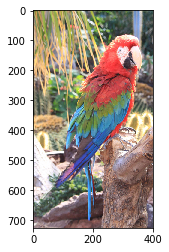

In [8]:
img = Image.open('data/parrot.jpg')
imshow(np.asarray(img))

Do the actual prediction:

In [9]:
predicted_class = engine.ClassifyWithImage(img, top_k=1)
print("Predicted class with id %d with probability %3.5f"%tuple(predicted_class[0]))
print("Decoded class: ", labels[ predicted_class[0][0]])

Predicted class with id 923 with probability 0.77734
Decoded class:  Ara macao (Scarlet Macaw)


Getting more predictions:

In [10]:
for result in engine.ClassifyWithImage(img, top_k=5):
    print(labels[result[0]] ," with score ", result[1])

Ara macao (Scarlet Macaw)  with score  0.77734375


Why this doesn't work? API has an predifined threshold for the predictions (0.1). We can lower this threshold if we are not able to get additional predictions (or even set to 0 to get all of them):

In [11]:
for result in engine.ClassifyWithImage(img, top_k=5, threshold=0.01):
    print(labels[result[0]] ," with score ", result[1])

Ara macao (Scarlet Macaw)  with score  0.77734375
Platycercus elegans (Crimson Rosella)  with score  0.0703125
Coracias caudatus (Lilac-breasted Roller)  with score  0.015625
Alisterus scapularis (Australian King-Parrot)  with score  0.01171875


Let's also classify the other image:

Predicted class with id 630 with probability 0.78516
Decoded class:  Haliaeetus leucocephalus (Bald Eagle)


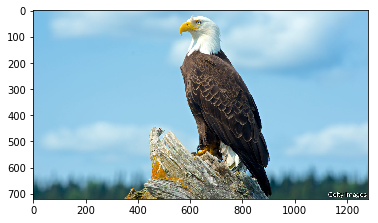

In [12]:
img = Image.open('data/20181006_BLP501.jpg')
imshow(np.asarray(img))
predicted_class = engine.ClassifyWithImage(img, top_k=1)
print("Predicted class with id %d with probability %3.5f"%tuple(predicted_class[0]))
print("Decoded class: ", labels[ predicted_class[0][0]])

Inference is just a piece of cake!

Let's also measure the time needed for the inference of this image:

In [13]:
from time import time
a = time()
predicted_class = engine.ClassifyWithImage(img, top_k=1)
b= time()
print("Spend ", 1000*(b-a), "msec")
print("FPS:", 1.0/(b-a))

Spend  2.906322479248047 msec
FPS: 344.0774405250205
